# Part One

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
base.prepare(engine, reflect = True)
# reflect the tables
base.metadata.tables

FacadeDict({'measurement': Table('measurement', MetaData(), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [6]:
# too hard to read, so will use inspector
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
measure_col = inspector.get_columns('measurement')
for i in measure_col:
    print(i['name'], i["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
station_col = inspector.get_columns('station')
for i in station_col:
    print(i['name'], i["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.stationa

In [11]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)
base.metadata.create_all(engine)

## Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
measurement_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print(measurement_recent_date)

2017-08-23


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_yr_delta = dt.datetime.strptime(measurement_recent_date, '%Y-%m-%d') - dt.timedelta(days = 365)
print(one_yr_delta)

# Perform a query to retrieve the data and precipitation scores
one_yr_data = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                      filter(Measurement.date >= one_yr_delta).\
                      group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(one_yr_data, columns=['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace = True)
prcp_df.head()

2016-08-23 00:00:00


,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


In [14]:
# Sort the dataframe by date
sorted_prcp_df = prcp_df.sort_index()
sorted_prcp_df

,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


<function matplotlib.pyplot.show(close=None, block=None)>

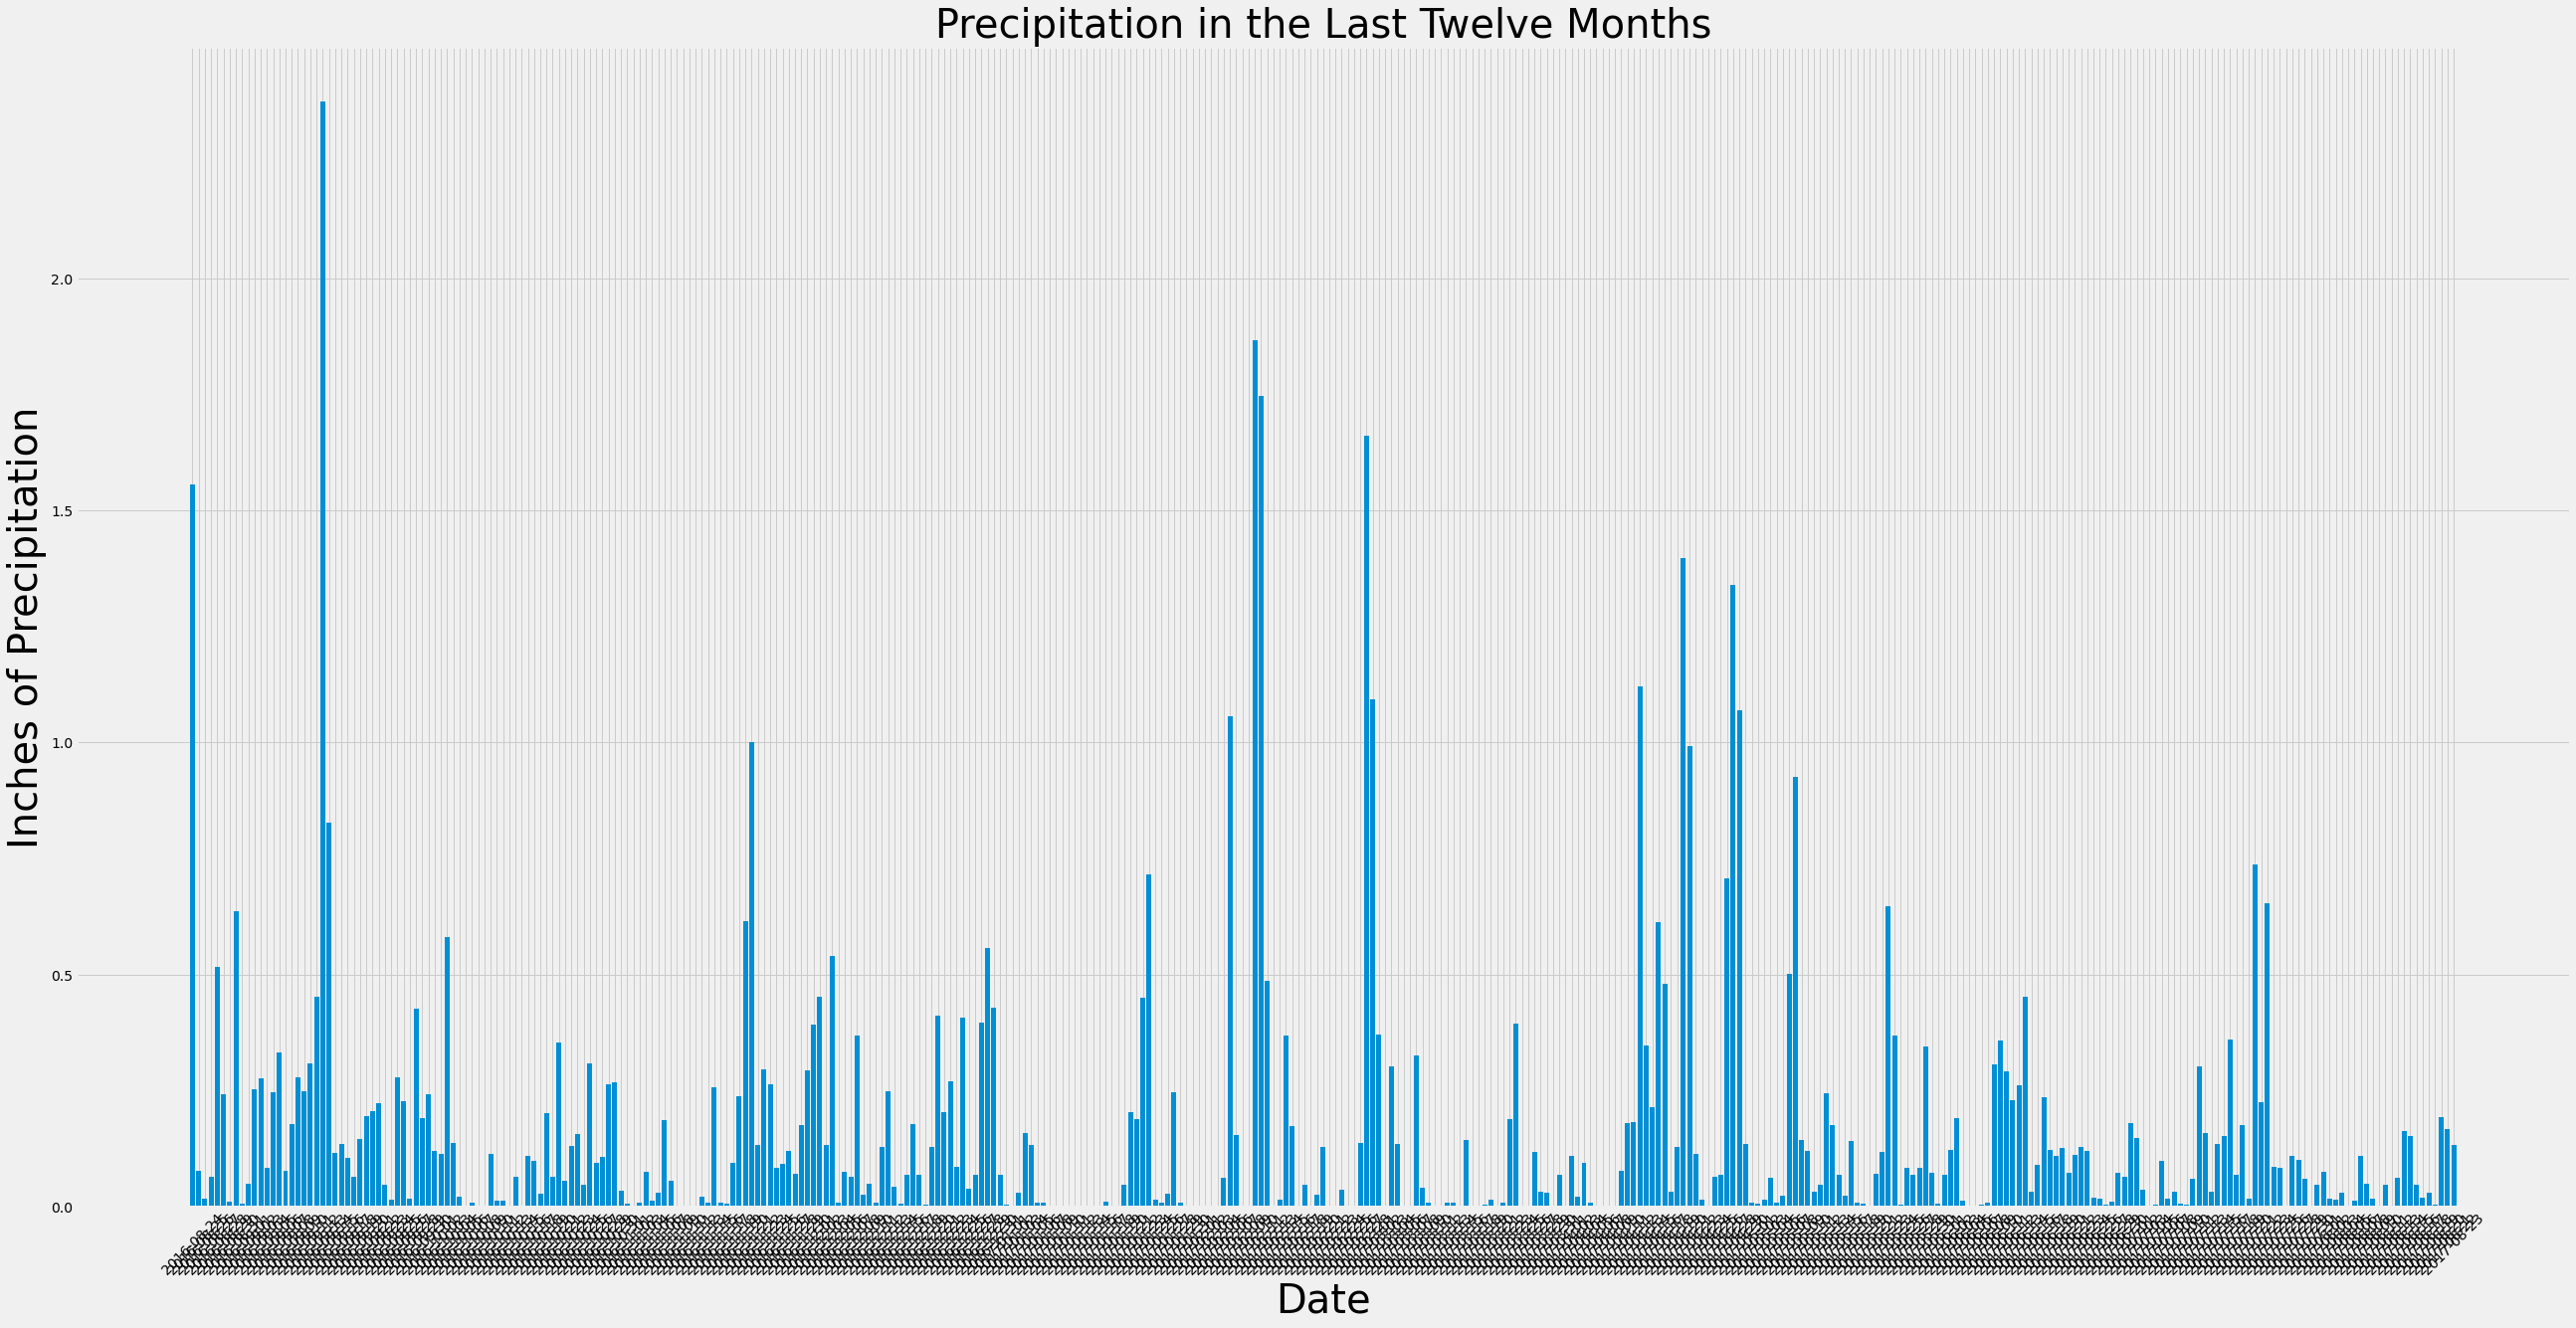

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize = (40,20))
plt.title("Precipitation in the Last Twelve Months", fontsize = 40)
plt.xlabel("Date", fontsize = 40)
plt.ylabel("Inches of Precipitation", fontsize = 40)
plt.xticks(rotation = 45)
plt.bar(sorted_prcp_df.index.values, sorted_prcp_df['Precipitation'])
plt.savefig("Output/Precipitation_Figure.png")
plt.show

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_prcp_df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


## Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.id).count()
total_stations

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_data = session.query(Measurement.station, func.count(Measurement.station)).\
                      group_by(Measurement.station).\
                      order_by(func.count(Measurement.station).desc()).all()
active_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = active_data[0][0]
active_station_data = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                              filter(Measurement.station == active_station).all()
active_station_data
print(f"Min: {active_station_data[0][0]}, Avg: {active_station_data[0][1]}, Max: {active_station_data[0][2]}")

Min: 54.0, Avg: 71.66378066378067, Max: 85.0


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
active_station_temp_data = session.query(Measurement.station, Measurement.tobs).\
                                   filter(Measurement.station == active_station).\
                                   filter(Measurement.date >= one_yr_delta).all()
active_station_temp_data[0:5]

[('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 75.0),
 ('USC00519281', 73.0)]

In [21]:
# importing data into pandas
temp_df = pd.DataFrame(active_station_temp_data, columns=['Station', 'Temperature'])
temp_df.set_index('Station', inplace = True)
temp_df.head()

,Temperature
Station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


<function matplotlib.pyplot.show(close=None, block=None)>

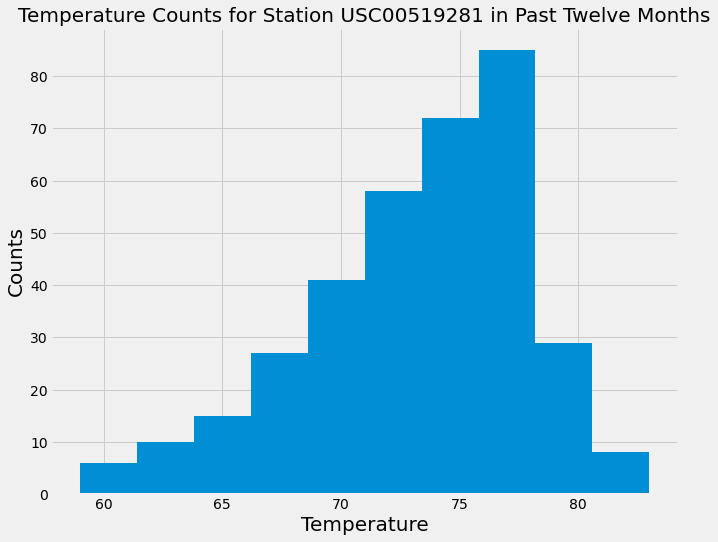

In [22]:
# plot the results as a histogram
plt.figure(figsize = (10, 8))
plt.title(f"Temperature Counts for Station {active_station} in Past Twelve Months", fontsize = 20)
plt.xlabel("Temperature", fontsize = 20)
plt.ylabel("Counts", fontsize = 20)
plt.hist(temp_df['Temperature'])
plt.savefig("Output/Temperature_Figure.png")
plt.show

## Close session

In [23]:
# Close Session
session.close()

# Part Two

## Dependencies

In [27]:
from flask import Flask, jsonify

## Server Setup

In [65]:
app = Flask(__name__)

# index/home route
@app.route("/")
def home():
    print("Server received request for '/' page...")
    return (
        f"Home Page<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end><br/>"
    )

# /api/v1.0/precipitation
@app.route("/api/v1.0/precipitation")
def precipitation():
    print("Server received request for '/api/v1.0/precipitation' page...")
    prcp_dict = sorted_prcp_df.to_dict()
    return jsonify(prcp_dict)

# /api/v1.0/stations
@app.route("/api/v1.0/stations")
def stations():
    print("Server received request for '/api/v1.0/stations' page...")
    station_names = [active_data[i][0] for i in range(len(active_data))]
    return jsonify(station_names)

# /api/v1.0/tobs
@app.route("/api/v1.0/tobs")
def tobs():
    print("Server received request for '/api/v1.0/tobs' page...")
    temp_ls = temp_df['Temperature'].to_list()
    return jsonify(temp_ls)

# /api/v1.0/<start>
@app.route("/api/v1.0/<start>")
def query(start):
    print("Server received request for '/api/v1.0/<start>' page...")
    values = sorted_prcp_df.loc[start:]['Precipitation'].to_list()
    output_ls = [min(values), sum(values)/len(values), max(values)]
    return jsonify(output_ls)

# /api/v1.0/<start>/<end>
@app.route("/api/v1.0/<start>/<end>")
def query2(start, end):
    print("Server received request for '/api/v1.0/<start>/<end>' page...")
    values = sorted_prcp_df.loc[start:end]['Precipitation'].to_list()
    output_ls = [min(values), sum(values)/len(values), max(values)]
    return jsonify(output_ls)

if __name__ == "__main__":
    app.run(debug=True)